In [1]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_yearly

from scipy.stats import boxcox
from scipy.special import inv_boxcox

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import mean_squared_error, mean_absolute_error

Importing plotly failed. Interactive plots will not work.


### Read the local temperature (local.csv) and energy consumption(power.csv) data as Dataframes

In [2]:
df_t = pd.read_csv('local.csv', index_col=0, parse_dates=True)
df_e = pd.read_csv('power.csv')

### power.csv contains billing month. Create a function to get the end date of previous month. i.e. the month of actual power consumption.

In [3]:
def getbill_endmn(x):
    return datetime.strptime('01-'+x, '%m-%y-%b') - timedelta(days=1)

# reindex 
df_e.index = df_e['Month'].apply(getbill_endmn)

### Local temperature data has a wide range compared to the energy consumption data. We will drop dditional months from temperature data.

In [4]:
# Get min and max date from the energy consumption data and filter temperature data

df_enan = df_e[df_e.isna().any(axis=1)]['kWh']
print(df_e.index.min() , df_e.index.max(), len(df_enan))

# Avg has many NAs, hence chosing min, max only
df_temp = df_t[df_t.index >= df_e.index.min()][['TMIN', 'TMAX']]

# Seasonal analysis doesn't work with na data, drop the na row from temperature data
# check for Nulls in temperature data, and drop (there are other options)
drpindx = df_temp[df_temp.isna().any(axis=1)].index
df_temp.drop(index=drpindx, inplace=True)

2010-12-31 00:00:00 2021-01-31 00:00:00 13


We expect power consumption to depend on both the minimum (heating) and maximum(cooling) temperatures. We will resample daily maximum, minimum temperature by month.
Apply filter on temperature data to match the energy consumption date range and plot the data. Observe gaps in the energy consumption data, we will fill the gaps later.

Notice the seasonality of temperature(this is expected) and power consumption. We don't see any particular trend.

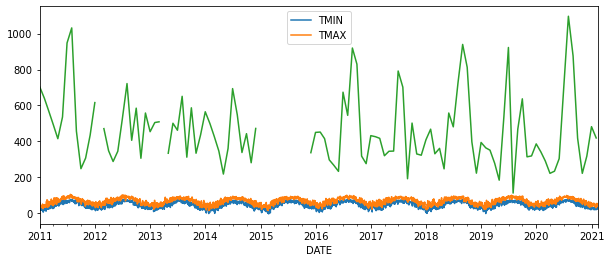

In [5]:
# plot temperature and power consumption
df_temp.plot(figsize=(10, 4))
_ = plt.plot(df_e['kWh'])

### We will calculate the monthly median kWh and fill the kWh nulls with the value for the month.

In [6]:
dct = {i:df_e[df_e.index.month==i].median() for i in range(1,13)}
filldct = {i:dct[i.month] for i in df_enan.index}
df_fill = pd.DataFrame.from_dict(filldct, orient='index', columns=['kWh',])
#df_fill

In [7]:
# Drop the extra month from temperature data, create a dataframe with temperature data and power consumption
mmed = df_temp['TMAX'].resample('M').median()
nmed = df_temp['TMIN'].resample('M').median()

nf_indx = set(mmed.index) - set(df_e.index)
df = pd.DataFrame({'TMax':mmed.tolist(), 'TMin':nmed.tolist()}, index=mmed.index)
df.drop(index=nf_indx, inplace=True)
df = pd.concat((df, df_e['kWh']), axis=1)

# Fill Null kWh with median calcuated above
df.update(df_fill)
# Verify Nulls
print("Total Null count", len(df[df.isna().any(axis=1)]))

Total Null count 0


In [8]:
# Get Avg monthly temperature 
dct_tmax_avg = {}
for mnth in range(1, 13):
    dct_tmax_avg[mnth] = df[df.index.month==mnth]['TMax'].mean()
dct_tmax_avg

{1: 42.36363636363637,
 2: 46.5,
 3: 54.4,
 4: 66.8,
 5: 76.8,
 6: 84.1,
 7: 89.1,
 8: 86.3,
 9: 79.45,
 10: 69.0,
 11: 56.1,
 12: 48.45454545454545}

### Visualize trend and seasonality of power consumption data to match our earlier assumption

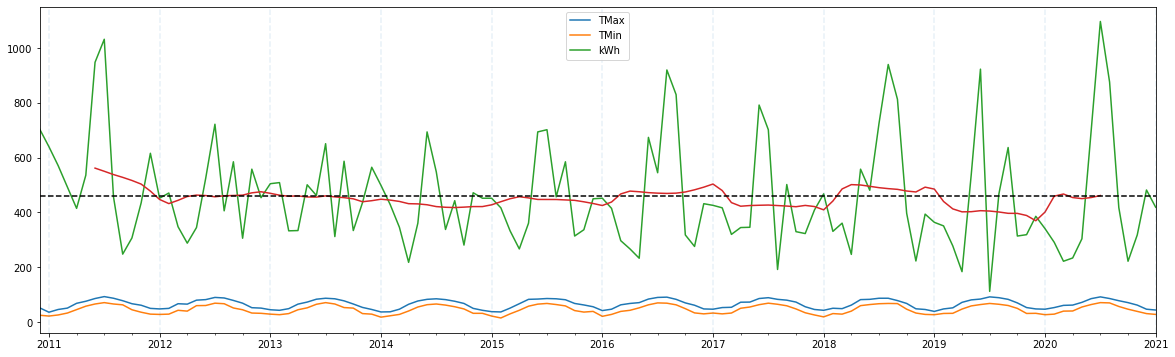

In [9]:
# Specify the (default) model type and period explicitly
ds = df['kWh']
result = seasonal_decompose(ds, model='additive', period=12)

fig = df.plot(figsize=(20, 6))
result.trend.plot()
for yr in ds.index.year.unique():
    fig.axvline(pd.to_datetime(str(yr)+'-01-01'), linestyle='--', alpha=0.1)
_ = fig.axhline(ds.mean(), linestyle='--', color='black')

We know the time series is stationary and has no trend. Feel free to refer the SARIMAX jupyter notebook for stationarity check.

## Prophet


In [10]:
# We will use boxcox tranformed data
bc, lmb = boxcox(ds)
print('Lambda: %.6f' % lmb)

def c_inv_boxcox(pred):
    return inv_boxcox(pred, lmb)

Lambda: 0.022530


In [11]:
#Model setup with additional regressors or seasonality
#We can set yearly_seasonality=False and then add custom seasonality with the below functions and season dictionary

# Hotter months
def summer(ds):
    if pd.to_datetime(ds).month in (6,7,8):
        return 1
    else:
        return 0
    
# Cooler months in spring, fall
def spring(ds):
    if pd.to_datetime(ds).month in (3,4):
        return 1
    else:
        return 0
    
def fall(ds):
    if pd.to_datetime(ds).month in (10,11):
        return 1
    else:
        return 0

def TMax(ds):
    try:
        return df[df.index==ds]['TMax'].values[0] 
    except IndexError:
        # For future month forecasts return average temperature for the month
        return dct_tmax_avg[pd.to_datetime(ds).month]
    
def get_mdl(df, regs=None, seasons=None):
    #if yearly_seasonality=True then  fourier_order is default 10
    #we don't have a trend in the data, setting it to 0
    #set seasonality_prior_scale to adjust the extent to which the seasonality model will fit the data, default=10.0 
    mdl = Prophet(yearly_seasonality=18, weekly_seasonality=False, 
                  daily_seasonality=False, seasonality_mode='additive'
                 )
    #Dictionary - Season: [period, fourier_order, prior_scale]; prior_scale only for regressor
    dct_season = {"spring": [61, 2, 10.0], "fall": [61, 2, 10.0], "summer": [91, 10, 1.0], "TMax": [0, 0, 0.1]}
    if regs:
        for each in regs:
            mdl.add_regressor(each, prior_scale=dct_season[each][2])
            
    if seasons:
        for each in seasons:
            mdl.add_seasonality(name=each, condition_name=each, 
                                period=dct_season[each][0], 
                                fourier_order=dct_season[each][1],
                                prior_scale=dct_season[each][2]
                               )
    return mdl.fit(df)

In [12]:
# Split data into train, test. Set 1 year data as test data
df['ds'] = df.index
df['y'] = boxcox(df['kWh'])[0]

df['summer'] = df['ds'].apply(summer)
df['spring'] = df['ds'].apply(spring)
df['fall'] = df['ds'].apply(fall)

df_train = df[df.index < '2020-02-01']
df_test = df[df.index >= '2020-02-01']
print(len(ds), len(df_test), len(df_train))


122 12 110


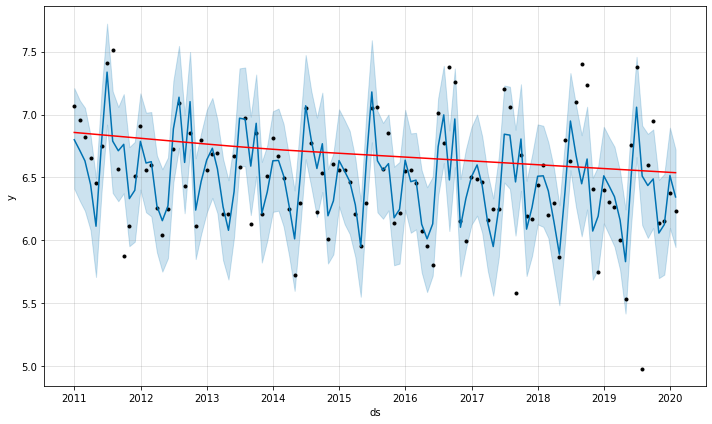

In [13]:
mdl = get_mdl(df_train)
trn = mdl.make_future_dataframe(periods=0)
pred_trn = mdl.predict(trn)
pred_trn.index = pred_trn["ds"]

fig = mdl.plot(pred_trn)
_ = add_changepoints_to_plot(fig.gca(), mdl, pred_trn)
#_ = plot_yearly(mdl)
#_ = mdl.plot_components(pred_trn)

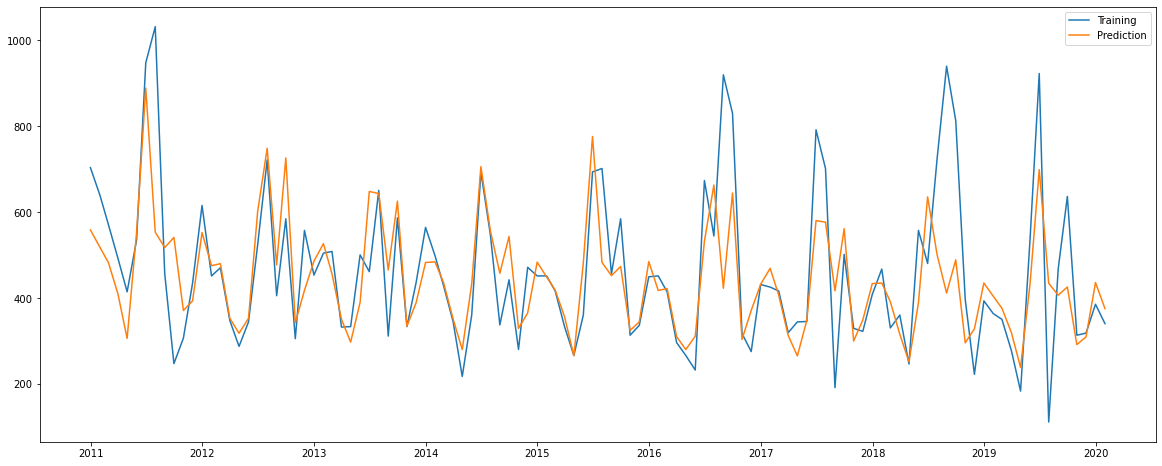

In [14]:
# Visualize fitted values
def plt_pred(dct, ysize=8):
    plt.figure(figsize=(20, ysize))
    lgnd = []
    for k, v in dct.items():
        plt.plot(c_inv_boxcox(v))
        lgnd.append(k)
    _ = plt.legend(lgnd)

plt_pred({"Training": df_train["y"], "Prediction": pred_trn["yhat"]})

### Explore Training residuals

In [15]:
def print_score(dset, pred, rsd, dstype="Training", print_out=True):
    rmse = mean_squared_error(dset, pred, squared=False)
    mae = mean_absolute_error(dset, pred)
    me = (dset - pred).sum()/len(dset)
    if print_out:
        print("%s yhat RMSE: %.6f" % (dstype, rmse))
        print("%s yhat Mean Absolute Error: %.6f" % (dstype, mae))
        print("%s yhat Mean Error: %.6f"  % (dstype, me))
        print("\nResiduals Summary:")
    print(rsd.describe())
    return rmse, mae, me 
          
rsd_train_yhat = df_train["y"] - pred_trn["yhat"]
prophet_trn_yhat_score = print_score(df_train["y"], pred_trn["yhat"], rsd_train_yhat, print_out=False)

count    110.000000
mean       0.000123
std        0.314225
min       -1.531928
25%       -0.127380
50%       -0.019993
75%        0.145633
max        0.953245
dtype: float64


In [16]:
rsd_train_yhatL = df_train["y"] - pred_trn["yhat_lower"]
prophet_trn_yhatL_score = print_score(df_train["y"], pred_trn["yhat_lower"], rsd_train_yhatL, print_out=False)

count    110.000000
mean       0.397431
std        0.315266
min       -1.141429
25%        0.271849
50%        0.382694
75%        0.548553
max        1.371563
dtype: float64


In [17]:
rsd_train_yhatU = df_train["y"] - pred_trn["yhat_upper"]
prophet_trn_yhatU_score = print_score(df_train["y"], pred_trn["yhat_upper"], rsd_train_yhatU, print_out=False)

count    110.000000
mean      -0.396036
std        0.314994
min       -1.933769
25%       -0.519502
50%       -0.413640
75%       -0.252696
max        0.566877
dtype: float64


In [18]:
# Display the forecast measures for yhat, yhat_lower, yhat_upper
display(pd.DataFrame({"Type": ("Train RMSE", "Train MAE", "Train ME"),
                   "yhat": prophet_trn_yhat_score,
                   "yhat_lower": prophet_trn_yhatL_score,
                   "yhat_upper": prophet_trn_yhatU_score
                  })
       )

,Type,yhat,yhat_lower,yhat_upper
0,Train RMSE,0.312793,0.506400,0.505137
1,Train MAE,0.207159,0.437346,0.427123
2,Train ME,0.000123,0.397431,-0.396036


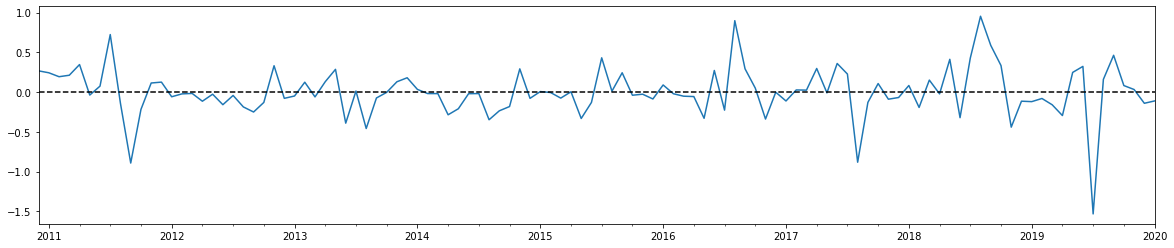

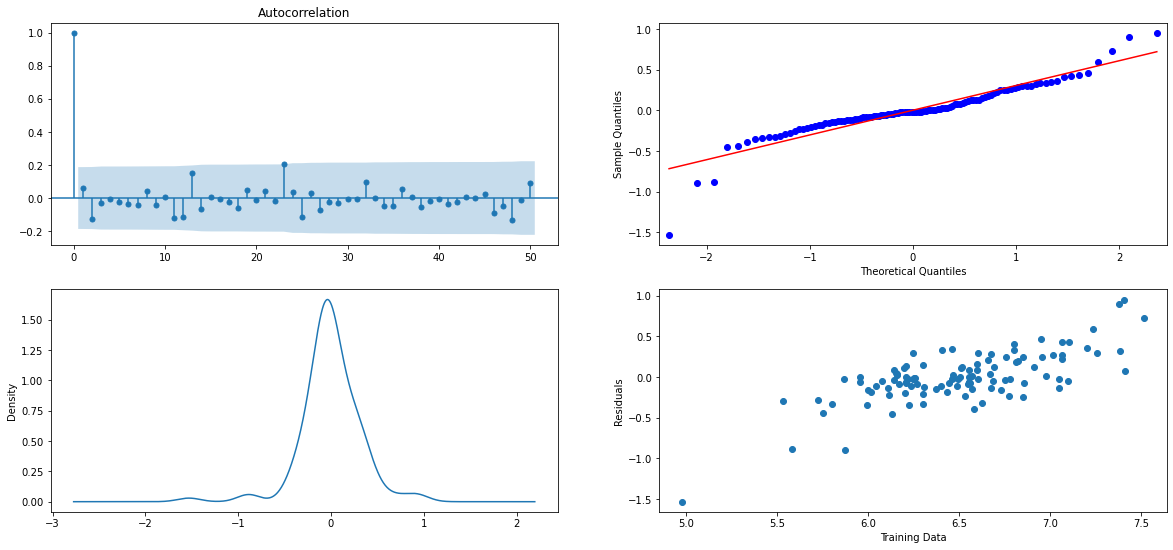

In [19]:
def explore_resid_custom(rsd, data, xlabel, lags=None):
    fig = rsd.plot(figsize=(20, 4))
    fig.axhline(rsd.mean(), linestyle='--', color='black')
    fig, axes = plt.subplots(2, 2, figsize=(20, 9))

    plot_acf(rsd, lags=lags, ax=axes[0, 0])
    qqplot(rsd, line='r', ax=axes[0, 1])

    rsd.plot(kind='kde', ax=axes[1, 0])
    plt.scatter(x=data, y=rsd)
    plt.xlabel(xlabel)
    _ = plt.ylabel('Residuals')
    
explore_resid_custom(rsd_train_yhat, df_train["y"], 'Training Data', 50)

### Let's check how the model performs on Test data

In [20]:
#Perform  rolling forecast on Test
df_tst_trn = df_train
cntr = df_tst_trn["y"].count()
pred_test = []
for i in df_test.index:
    mdl_t = get_mdl(df_tst_trn)
    tst = mdl_t.make_future_dataframe(periods=1, freq='M')
    prd_tst = mdl_t.predict(tst)
    pred = prd_tst[prd_tst.index==cntr]["yhat"].values[0]
    pred_test.append(pred)
    df_tst_trn = pd.concat((df_train, df_test[df_test.index <= i]))
    cntr += 1 
    indx = i.strftime('%Y-%m-%d')
    print(indx, "Actual:%.2f, Forecast:%.2f" % (c_inv_boxcox(df_test[df_test.ds==indx]["y"][0]), c_inv_boxcox(pred)))

2020-02-29 Actual:291.00, Forecast:380.08
2020-03-31 Actual:222.00, Forecast:273.75
2020-04-30 Actual:234.00, Forecast:252.82
2020-05-31 Actual:304.00, Forecast:261.50
2020-06-30 Actual:697.00, Forecast:464.98
2020-07-31 Actual:1097.00, Forecast:598.61
2020-08-31 Actual:876.00, Forecast:389.95
2020-09-30 Actual:418.00, Forecast:619.32
2020-10-31 Actual:222.00, Forecast:286.54
2020-11-30 Actual:318.00, Forecast:338.03
2020-12-31 Actual:482.00, Forecast:403.63
2021-01-31 Actual:419.00, Forecast:424.82


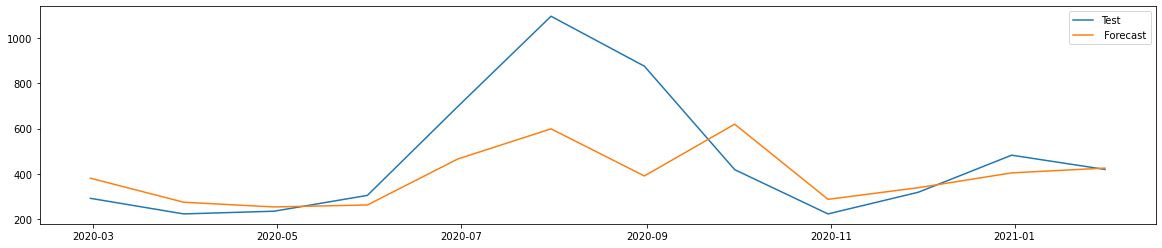

In [21]:
#Visualize forecast on test data
ds_pred_test = pd.Series(pred_test, index=df_test.index)
plt_pred({'Test':df_test["y"], ' Forecast':ds_pred_test}, 4)

### Explore Test Forecast errors

In [22]:
rsd_test_yhat = df_test["y"] - pred_test
prophet_test_yhat_score = print_score(df_test["y"], pred_test, rsd_test_yhat)

Training yhat RMSE: 0.419098
Training yhat Mean Absolute Error: 0.328021
Training yhat Mean Error: 0.085349

Residuals Summary:
count    12.000000
mean      0.085349
std       0.428560
min      -0.452409
25%      -0.250174
50%      -0.042704
75%       0.269402
max       0.934280
Name: y, dtype: float64


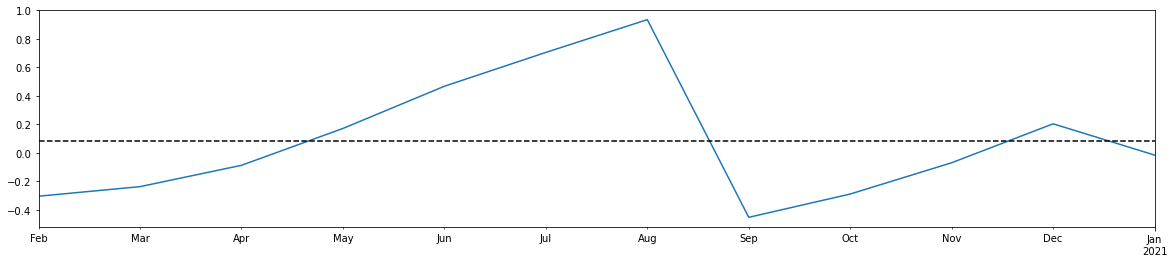

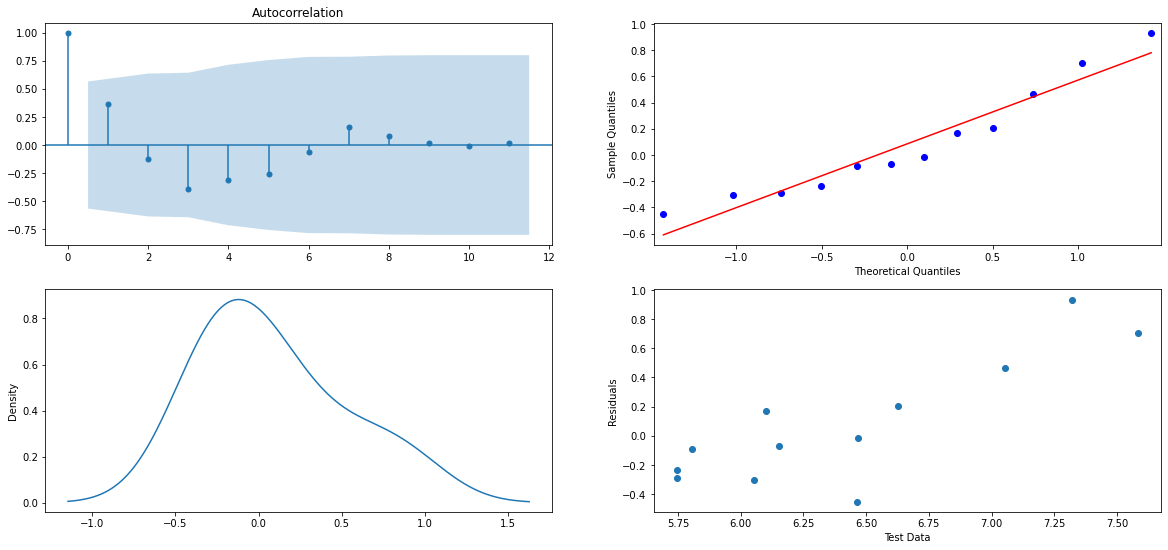

In [23]:
explore_resid_custom(rsd_test_yhat, df_test["y"], 'Test Data')

Forecasted power consumption for 2021-Feb: 362.36


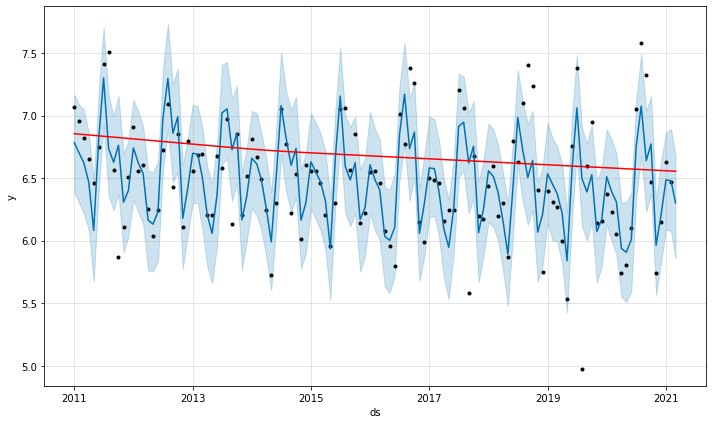

In [24]:
mdl_fnl = get_mdl(df_tst_trn)
fnl = mdl_fnl.make_future_dataframe(periods=1, freq='M')
prd_fnl = mdl_fnl.predict(fnl)
pred = prd_fnl.tail(1)[["ds", "yhat"]]
nxt_month = c_inv_boxcox(pred.yhat.values[0])
fig = mdl_fnl.plot(prd_fnl)
_ = add_changepoints_to_plot(fig.gca(), mdl_fnl, prd_fnl)
print("Forecasted power consumption for %s: %.2f" % (pd.to_datetime(str(pred.ds.values[0])).strftime('%Y-%b'), 
                                                     nxt_month))

### Actual power consumption for 2021-02: 362kWh

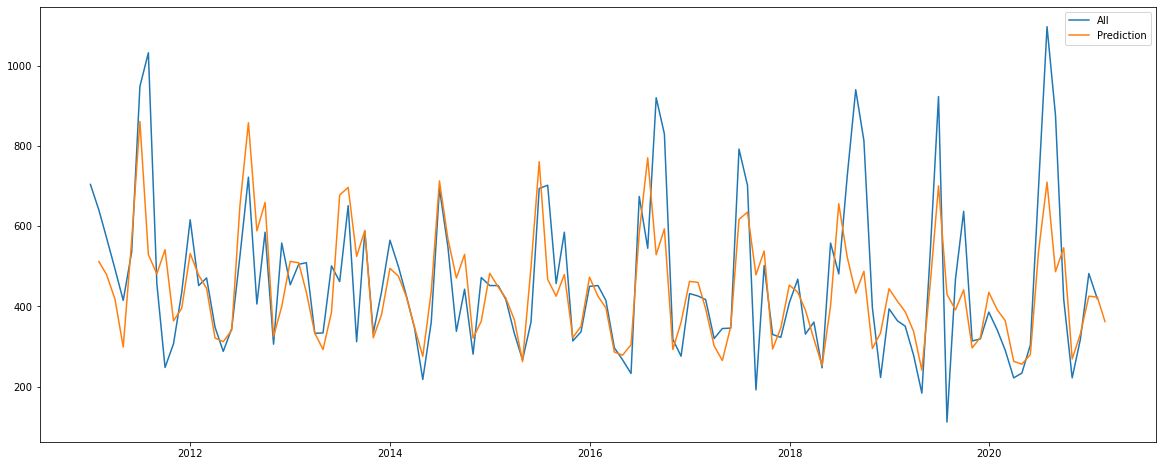

In [25]:
# Plot predictions on all
df_fnl_show = pd.DataFrame(prd_fnl.tail(-1)["yhat"])
df_fnl_show.index=prd_fnl.tail(-1)["ds"]
plt_pred({"All": df_tst_trn["y"], "Prediction": df_fnl_show["yhat"]})

## Prophet with Additional regressors

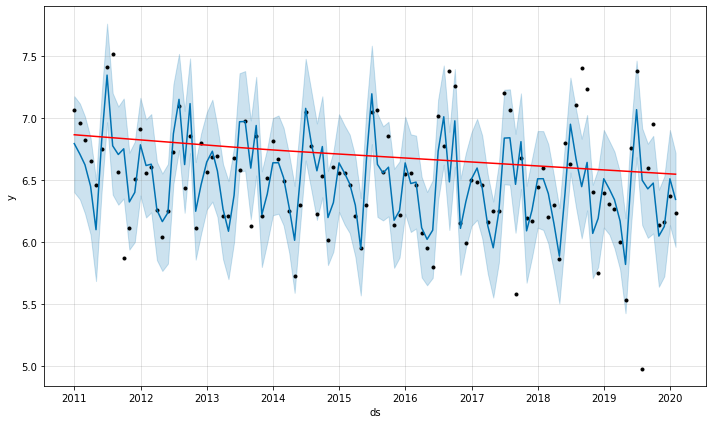

In [26]:
#Available ('TMax', 'fall', 'spring', 'summer')
#TMax - use as external regressor only
regressors = ('fall', 'spring')
seasons_used = ()
              
def apply_reg_seasons(df):
    if regressors is None:
        lst = seasons_used
    elif seasons_used is None:
        lst = regressors
    else:
        lst = (seasons_used + regressors)
    if 'summer' in lst:
        df['summer'] = df['ds'].apply(summer)
    if 'fall' in lst:
        df['fall'] = df['ds'].apply(fall)    
    if 'spring' in lst:
        df['spring'] = df['ds'].apply(spring)
    if 'TMax' in lst:
        df['TMax'] = df['ds'].apply(TMax)
    
mdl_x = get_mdl(df_train, regs=regressors, seasons=seasons_used)
trn_x = mdl_x.make_future_dataframe(periods=0)
apply_reg_seasons(trn_x)
pred_trn_x = mdl_x.predict(trn_x)
pred_trn_x.index = pred_trn_x["ds"]

fig = mdl_x.plot(pred_trn_x)
_ = add_changepoints_to_plot(fig.gca(), mdl_x, pred_trn_x)

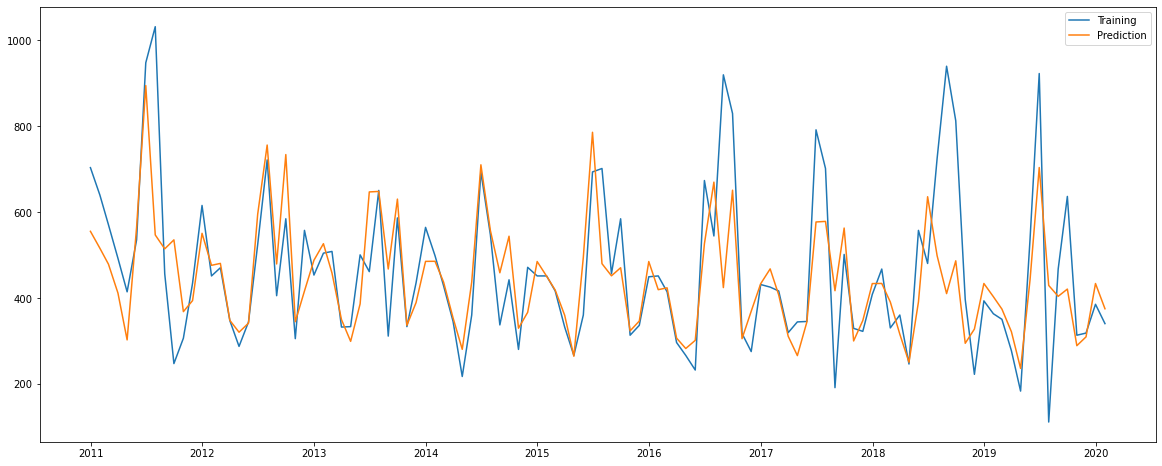

In [27]:
plt_pred({"Training": df_train["y"], "Prediction": pred_trn_x["yhat"]})

In [28]:
rsd_train_yhat_x = df_train["y"] - pred_trn_x["yhat"]
prophet_trn_yhat_score_x = print_score(df_train["y"], pred_trn_x["yhat"], rsd_train_yhat_x)

Training yhat RMSE: 0.312950
Training yhat Mean Absolute Error: 0.207887
Training yhat Mean Error: 0.000189

Residuals Summary:
count    110.000000
mean       0.000189
std        0.314382
min       -1.518694
25%       -0.130510
50%       -0.021627
75%        0.144428
max        0.956711
dtype: float64


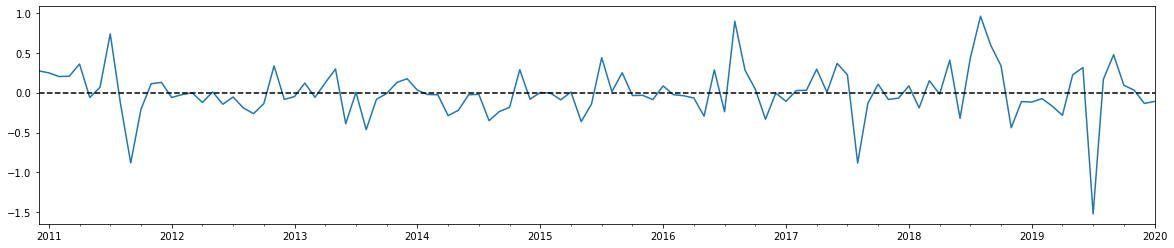

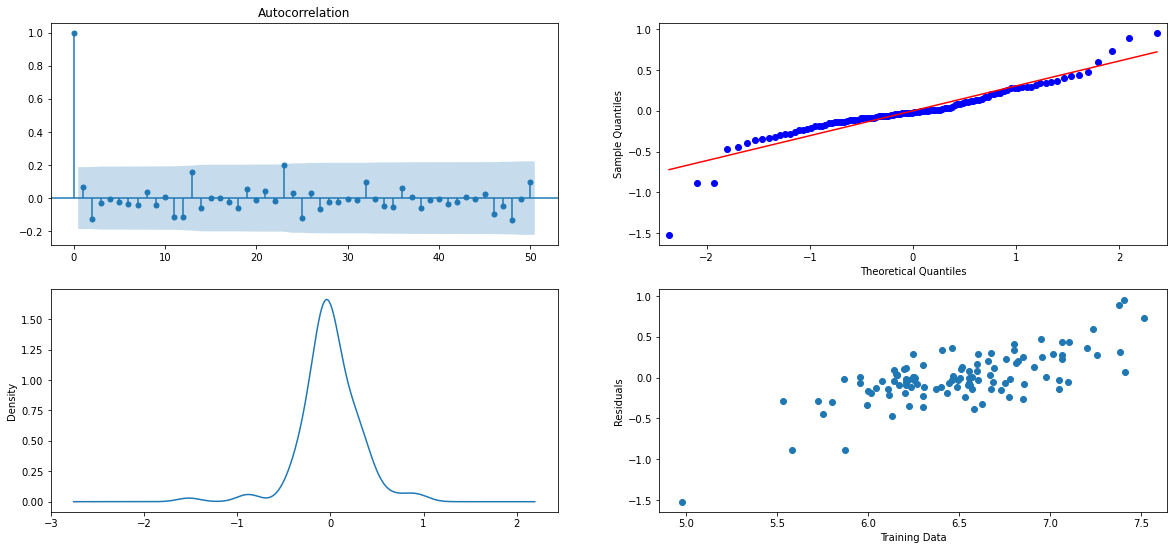

In [29]:
explore_resid_custom(rsd_train_yhat_x, df_train["y"], 'Training Data', 50)

In [30]:
#Perform  rolling forecast on Test
df_tst_trn = df_train
cntr = df_tst_trn["y"].count()
pred_test_x = []
for i in df_test.index:
    mdl_t_x = get_mdl(df_tst_trn, regs=regressors, seasons=seasons_used)
    tst_x = mdl_t_x.make_future_dataframe(periods=1, freq='M')
    apply_reg_seasons(tst_x)
    prd_tst_x = mdl_t_x.predict(tst_x)
    pred = prd_tst_x[prd_tst_x.index==cntr]["yhat"].values[0]
    pred_test_x.append(pred)
    df_tst_trn = pd.concat((df_train, df_test[df_test.index <= i]))
    cntr += 1 
    indx = i.strftime('%Y-%m-%d')
    print(indx, "Actual:%.2f, Forecast:%.2f" % (c_inv_boxcox(df_test[df_test.ds==indx]["y"][0]), c_inv_boxcox(pred)))

2020-02-29 Actual:291.00, Forecast:379.43
2020-03-31 Actual:222.00, Forecast:271.44
2020-04-30 Actual:234.00, Forecast:250.16
2020-05-31 Actual:304.00, Forecast:258.66
2020-06-30 Actual:697.00, Forecast:467.91
2020-07-31 Actual:1097.00, Forecast:592.71
2020-08-31 Actual:876.00, Forecast:390.36
2020-09-30 Actual:418.00, Forecast:606.54
2020-10-31 Actual:222.00, Forecast:282.90
2020-11-30 Actual:318.00, Forecast:337.57
2020-12-31 Actual:482.00, Forecast:400.10
2021-01-31 Actual:419.00, Forecast:428.10


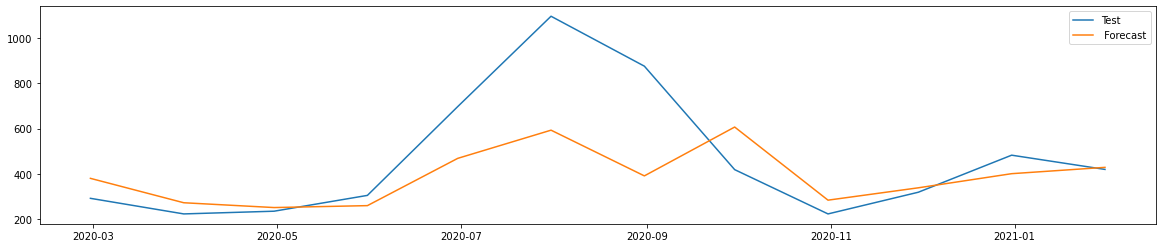

In [31]:
#Visualize forecast on test data
ds_pred_test_x = pd.Series(pred_test_x, index=df_test.index)
plt_pred({'Test':df_test["y"], ' Forecast':ds_pred_test_x}, 4)

In [32]:
rsd_test_yhat_x = df_test["y"] - pred_test_x
prophet_test_yhat_score_x = print_score(df_test["y"], pred_test_x, rsd_test_yhat_x)

Training yhat RMSE: 0.417009
Training yhat Mean Absolute Error: 0.325565
Training yhat Mean Error: 0.092047

Residuals Summary:
count    12.000000
mean      0.092047
std       0.424809
min      -0.428316
25%      -0.239331
50%      -0.046326
75%       0.275131
max       0.933090
Name: y, dtype: float64


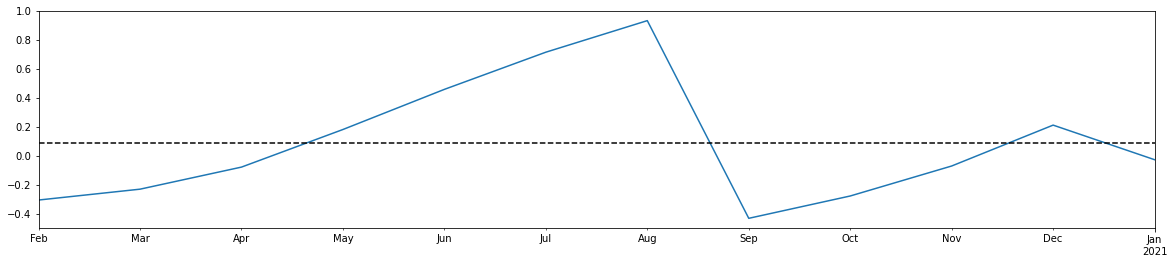

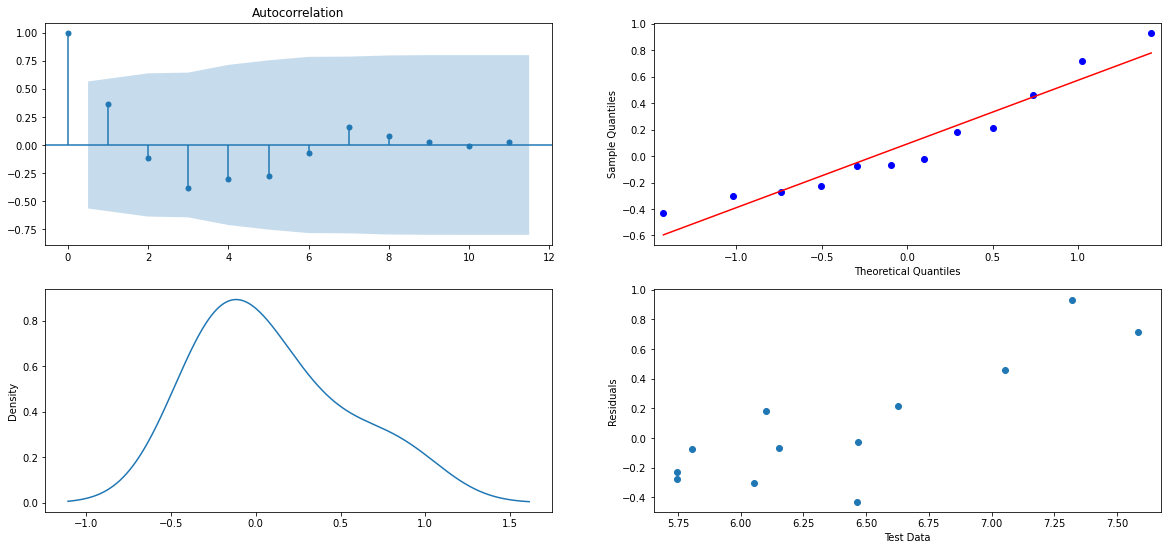

In [33]:
explore_resid_custom(rsd_test_yhat_x, df_test["y"], 'Test Data')

Additional Regressors: ('fall', 'spring')
Additional seasonality: ()
Forecasted power consumption for 2021-Feb: 360.35


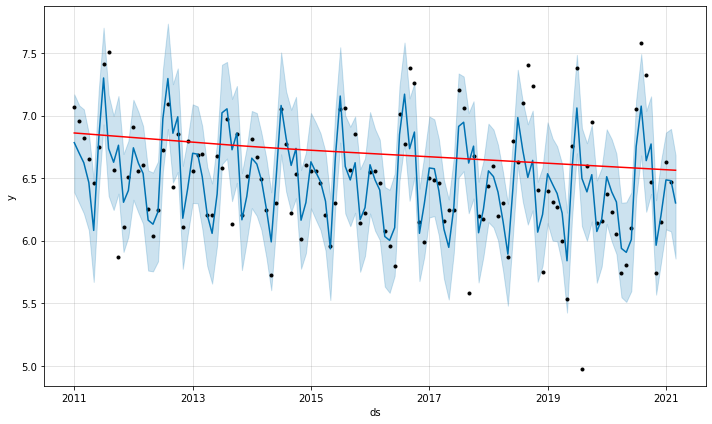

In [34]:
mdl_fnl_x = get_mdl(df_tst_trn, regs=regressors, seasons=seasons_used)
fnl_x = mdl_fnl.make_future_dataframe(periods=1, freq='M')
apply_reg_seasons(fnl_x)
prd_fnl_x = mdl_fnl_x.predict(fnl_x)

pred = prd_fnl_x.tail(1)[["ds", "yhat"]]
nxt_month_x = c_inv_boxcox(pred.yhat.values[0])
fig = mdl_fnl_x.plot(prd_fnl)
_ = add_changepoints_to_plot(fig.gca(), mdl_fnl_x, prd_fnl_x)
print("Additional Regressors:", regressors)
print("Additional seasonality:", seasons_used)
print("Forecasted power consumption for %s: %.2f" % (pd.to_datetime(str(pred.ds.values[0])).strftime('%Y-%b'), 
                                                     nxt_month_x))

### Actual power consumption for 2021-02: 362kWh

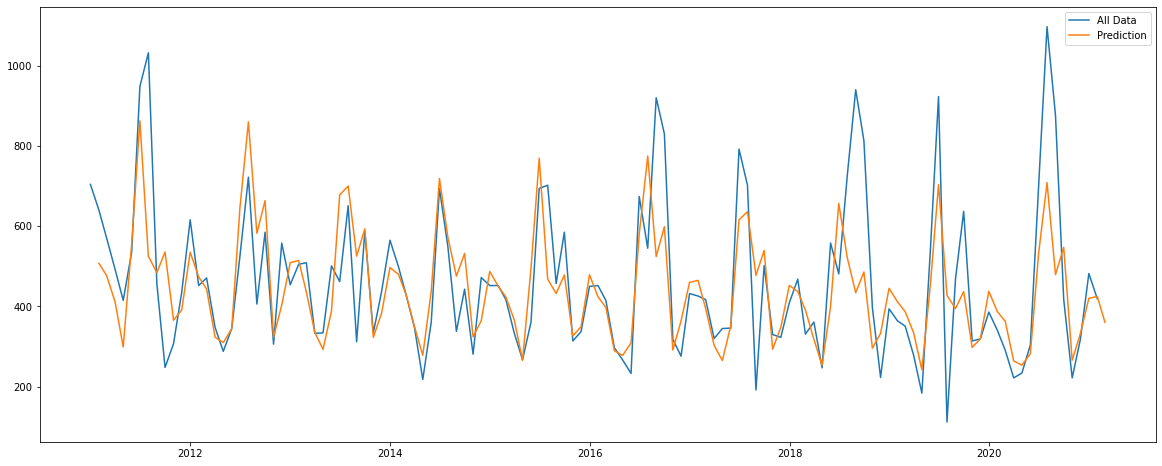

In [35]:
# Plot predictions on all
df_fnl_show = pd.DataFrame(prd_fnl_x.tail(-1)["yhat"])
df_fnl_show.index=prd_fnl_x.tail(-1)["ds"]
plt_pred({"All Data": df_tst_trn["y"], "Prediction": df_fnl_show["yhat"]})

In [36]:
display(pd.DataFrame({"Type": ("Train RMSE", "Train MAE", "Train ME", "Test RMSE", "Test  MAE", "Test  ME", "Next Forecast"),
                   "Prophet": (prophet_trn_yhat_score + prophet_test_yhat_score + (nxt_month,)),
                   "Prophet+Reg": (prophet_trn_yhat_score_x + prophet_test_yhat_score_x + (nxt_month_x,))
                  })
       )

,Type,Prophet,Prophet+Reg
0,Train RMSE,0.312793,0.312950
1,Train MAE,0.207159,0.207887
2,Train ME,0.000123,0.000189
3,Test RMSE,0.419098,0.417009
4,Test MAE,0.328021,0.325565
5,Test ME,0.085349,0.092047
6,Next Forecast,362.361639,360.350111


## Conclusion:
- Prophet performs better than ARMA,SARMA and closer to SARMAX without tuning any hyper parameters.
- Only a change to fourier_order was required to get a pretty good model.
- Prophet model performs a bit better on boxcox transformed data than actual values (modeling on actual values not shown).
- Prophet predictions and forecast is pretty good on average and low values, but the high values are off by a good margin.
- Prophet with regressors and/or seasons seems to be overfitting. After trying various combinations of regressors and seasons, ('fall', 'spring') as additional regressors, shown above, was the best i could get.
- Prophet with hyper parameter tuning(fourier_order) and without regressors is a good model.
- Hyper parameter tuning, trying extra regressors and/or custom seasonalities was a very interesting exercise.